# Topic Modelling on Negative Reviews

In [30]:
# import libraries
from pathlib import Path
import pandas as pd
import numpy as np
import gensim, spacy
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from joblib import dump
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
import pyLDAvis
import pyLDAvis.gensim_models
import warnings
warnings.filterwarnings("ignore")

In [31]:
# default
BASE_DIR = Path.cwd().parent
stop_words = stopwords.words('english')
PALETTE = px.colors.qualitative.Prism

In [32]:
# load the labeled data
df_hosts_reviews_en = pd.read_parquet(BASE_DIR / 'processed_data' / 'hosts_reviews_en_labeled.parquet')

In [33]:
# subset only negative reviews
df_hosts_reviews_en = df_hosts_reviews_en.query('sentiment_label_class == 0').reset_index()

In [34]:
# split text into words
def sent_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# convert to list
data = df_hosts_reviews_en['comments'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[0])

['stayed', 'three', 'nights', 'couldnt', 'helpful', 'soon', 'got', 'showed', 'us', 'get', 'around', 'visit', 'place', 'conveniently', 'located', 'metro', 'station', 'walking', 'distance', 'market', 'many', 'restaurants', 'clean', 'privacy', 'issue', 'despite', 'guests', 'staying', 'well', 'wifi', 'reliable', 'youre', 'vacation', 'doesnt', 'really', 'matter']


In [35]:
# preprocess data
nlp = spacy.load("en_core_web_sm")
stop_words.append('also')
bigram = gensim.models.Phrases(data_words, min_count=1, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    #Form Bigrams, Trigrams and Lemmatization
    #texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts] #already removed
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)

In [36]:
# create dictionary
id2word = corpora.Dictionary(data_ready)

# create corpus: term document frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# train a LDA model
lda = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=5,
                                           passes=5,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

dump(lda, f'saved_models/model_lda_neg.joblib')
lda.print_topics()

[(0,
  '0.019*"host" + 0.016*"apartment" + 0.015*"room" + 0.014*"stay" + 0.013*"bed" + 0.012*"place" + 0.011*"leave" + 0.011*"clean" + 0.011*"dirty" + 0.009*"get"'),
 (1,
  '0.037*"location" + 0.026*"apartment" + 0.021*"host" + 0.019*"need" + 0.016*"stay" + 0.015*"place" + 0.014*"close" + 0.010*"great" + 0.009*"right" + 0.009*"cleanliness"')]

In [37]:
# UDF to format topic sentences
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # create a dataframe
    sent_topics_df = pd.DataFrame(columns=['dominant_topic', 'percent_contribution', 'topic_keywords'])

    # get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # get the dominant topic, perc contribution and keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  #dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df.loc[len(sent_topics_df)] = [int(topic_num), round(prop_topic,3), topic_keywords]
            else:
                break


    # merge to the original dataframe
    contents = pd.Series(texts)
    contents.name = 'text'
    sent_topics_df = (df_hosts_reviews_en.merge(sent_topics_df, left_index=True, right_index=True)
                                    .merge(contents, left_index=True, right_index=True)
                                    .drop('index', axis=1))
    return(sent_topics_df)


df_dominant_topic = format_topics_sentences(ldamodel=lda, corpus=corpus, texts=data_ready)
df_dominant_topic.sample(3)

,level_0,date,listing_id_encod,listing_id,reviewer_id,reviewer_name,comments,host_id,host_name,host_description,...,review_scores_location,review_scores_value,comments_language,description_language,sentiment_label,sentiment_label_class,dominant_topic,percent_contribution,topic_keywords,text
20,2123,2016-03-27,7.0,299154.0,35860155.0,Nada,really great location surrounded many bars sho...,1541953.0,Daniel,cosy apartment central sodermalm centrally loc...,...,4.96,4.58,en,en,-0.0276,0,0,0.516,"host, apartment, room, stay, bed, place, leave...","[really, great, location, surround, many, bar,..."
850,51118,2020-02-16,1332.0,36783908.0,304797709.0,Daria,without inconvenience truly recommend,270945260.0,Generator,generator superior twin putting win back twin ...,...,4.83,4.41,en,en,-0.3412,0,0,0.799,"host, apartment, room, stay, bed, place, leave...","[inconvenience, truly, recommend]"
814,50339,2019-12-19,1329.0,36783661.0,36629311.0,Olivia,somewhere quite central within stockholm quite...,270945260.0,Generator,generator bed 6 bed dorm bother things notebbr...,...,4.77,4.55,en,en,0.0000,0,1,0.643,"location, apartment, host, need, stay, place, ...","[somewhere, quite, central, quite, decent, acc..."


In [38]:
# visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary=lda.id2word)
pyLDAvis.save_html(vis, 'lda_visualization_neg.html')
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.150503  0.0       1        1  69.818805
1     -0.150503  0.0       2        1  30.181195, topic_info=              Term        Freq       Total Category  logprob  loglift
33        location  227.000000  227.000000  Default  30.0000  30.0000
138           need  118.000000  118.000000  Default  29.0000  29.0000
154          close   84.000000   84.000000  Default  28.0000  28.0000
22       apartment  396.000000  396.000000  Default  27.0000  27.0000
168          great   65.000000   65.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
10           place   89.951329  255.535184   Topic2  -4.2291   0.1539
17            stay   96.117991  298.689411   Topic2  -4.1627   0.0641
176          space   29.979121   46.237855   Topic2  -5.3278   0.7647
354  communication   26.113331   41.894858   Topic2  -5.4659   0.7252
533           poor   24.741076   42.351112   Topic2  -5.5199   0.6604

[122 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
127       1  0.118657  advertise
127       2  0.909704  advertise
261       1  0.998074     airbnb
261       2  0.007859     airbnb
22        1  0.590569  apartment
...     ...       ...        ...
148       2  0.011648       want
338       1  0.988390     window
338       2  0.015206     window
514       1  0.994962       work
514       2  0.012283       work

[152 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [39]:
topics = lda.show_topics(formatted=False)

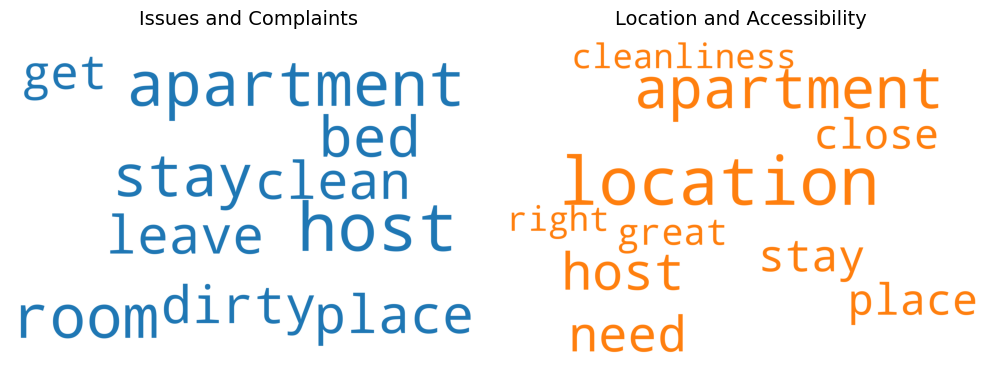

In [40]:
# create Word Clouds
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(1, 2, figsize=(10,10), sharex=True, sharey=True)

groups = {0: 'Issues and Complaints',
          1: 'Location and Accessibility'
        }

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=350)
    plt.gca().imshow(cloud)
    plt.gca().set_title(groups.get(i), fontdict=dict(size=14))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=30, hspace=10)
plt.axis('off')
#plt.margins(x=0, y=0)
plt.tight_layout()
#plt.savefig('topics_neg.png')
plt.show()

In [41]:
# calculate number of reviews by topic and neighbourhood
numnber_topic_by_neighbourhood = (df_dominant_topic.groupby(['neighbourhood', 'dominant_topic'])
        .agg(number_of_reviews=('number_of_reviews', 'count'))
        .sort_values('number_of_reviews', ascending=False)
        .reset_index())
numnber_topic_by_neighbourhood 

,neighbourhood,dominant_topic,number_of_reviews
0,Södermalm,0,330
1,Södermalm,1,266
2,Kungsholmen,0,88
3,Norrmalm,0,84
4,Kungsholmen,1,78
5,Norrmalm,1,66
6,Enskede-Årsta-Vantör,1,38
7,Enskede-Årsta-Vantör,0,30
8,Hägersten-Liljeholmen,0,22
9,Östermalm,0,22


In [42]:
# define a custom color mapping function
def get_tile_color(tile_path):
    # get the name of the neighbourhood and the dominant topic from the tile path
    neighbourhood, dominant_topic = tile_path[-2:]

    # assign a specific color to each combination of neighbourhood and dominant topic
    if dominant_topic == 'topic 0' and neighbourhood == 'Neighbourhood 1':
        return 'red'
    elif dominant_topic == 'topic 1' and neighbourhood == 'Neighbourhood 2':
        return 'green'
    else:
        # Use the default color scale for all other tiles
        return None

# create the treemap with the custom color mapping function
fig = px.treemap(
    numnber_topic_by_neighbourhood,
    path=['neighbourhood', 'dominant_topic'],
    values='number_of_reviews',
    color_discrete_sequence=PALETTE,
    color_continuous_midpoint=np.average(numnber_topic_by_neighbourhood['number_of_reviews']),
)

# apply the custom color mapping function to each tile
fig.data[0].marker.colors = [get_tile_color(tile_path) for tile_path in fig.data[0].ids]
fig.show()